# 汉字书法识别挑战


from [TinyMind第一届汉字书法识别挑战赛](http://www.tinymind.cn/competitions/41)

竞赛数据提供100个汉字书法单字，包括碑帖，手写书法，古汉字等等。图片全部为单通道灰度jpg，宽高不定。

**训练集**

训练集每个汉字400张图片，共计40000张图片，供参赛人员测试和开发参赛算法模型，训练集是标注好的数据，图片按照图片上的文字分类到不同的文件夹中，也就是说文件夹的名字就是文件夹里所有图片的标签。

**测试集**

每汉字100张图片共10000张图片，在竞赛过程中，供参赛人员测试算法模型使用，开放数据下载但不提供标签。比赛过程中，参赛队伍排名以第一部分数据的结果为准。

**提交csv文件**

文件第一列是测试集中图片文件的文件名，第二列是参赛队伍推断出来的图片上文字的可能的五个汉字。
> csv文件编码统一使用utf8编码

In [21]:
import os
import cv2
import glob

import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from os.path import isfile, isdir
from datetime import date
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

%matplotlib inline

In [2]:
# 检查文件是否正确下载
assert isfile('train.zip'), "No files: train.zip"
assert isfile('test1.zip'), "No files: test1.zip"

# 解压文件
if not isdir('train'):
    with ZipFile('train.zip', 'r') as zipf:
        for name in tqdm(zipf.namelist(), desc='Extract train_set', unit='files'):
            zipf.extract(name)
        zipf.close()

if not isdir('test1'):
    with ZipFile('test1.zip', 'r') as zipf:
        for name in tqdm(zipf.namelist(), desc='Extract test_set', unit='files'):
            zipf.extract(name)
        zipf.close()

print("All files extracted!")

Extract test_set: 100%|██████████| 10001/10001 [00:02<00:00, 3354.97files/s]

All files extracted!


In [3]:
print('./train/白/' + os.listdir('./train/白')[1])

./train/白/4819eda5cdf4aa61caa2c22764cef2011d0b0441.jpg


shape:  (128, 153)


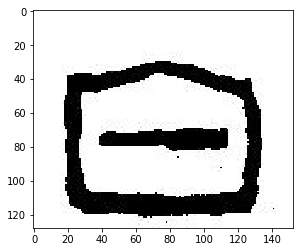

In [4]:
path_eg = './train/白/00801816ca06bdf0b07e56ddfa6c029eeda49dfc.jpg'

image_eg = cv2.imdecode(np.fromfile(path_eg, dtype=np.uint8), 0)

print('shape: ', image_eg.shape)
plt.imshow(image_eg, cmap='gray')
plt.show()

## 提取数据

### 训练集
提取train文件夹中的数据，生成对应的标签，并对标签进行独热编码。

In [5]:
# 建立缓存文件夹和提交文件夹
if not isdir('cache'):
    os.mkdir('cache')
if not isdir('submission'):
    os.mkdir('submission')

In [6]:
is_test = 1
random_seed = 2018

label_char = os.listdir('./train/')
encode_label = LabelBinarizer()
encode_label.fit(label_char)



LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [7]:
class_num = len(label_char)
print('class_num: ', class_num)

class_num:  100


In [8]:
# 将图片以 np.uint8 格式存储
def get_img(file_path, img_rows, img_cols):
    if ('test1' in file_path):
        image = cv2.imread(file_path, 0)
    else:    # 如果有中文路径
        image = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), 0)
    
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, (img_rows, img_cols))
    feature = np.array(image, dtype=np.uint8)
    
    return feature

(200, 200, 3)


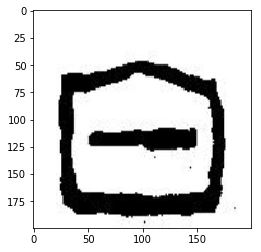

In [9]:
if is_test:
    path_eg = './train/白/00801816ca06bdf0b07e56ddfa6c029eeda49dfc.jpg'
    f = get_img(path_eg, 200, 200)
    print(f.shape)
    plt.imshow(f)
    plt.show()

In [20]:
def load_train_data(train_path, img_rows, img_cols, test_size=0.2):
    x_train = []
    y_train = []
    
    dirs = os.listdir(train_path)
    dirs_pbar = tqdm(dirs, desc='load train images', total=len(dirs))     #######################
    for dir_name in dirs_pbar:             
        path = train_path + '/' + dir_name
        for img_name in os.listdir(path):
            feature = get_img(path+'/'+img_name, img_rows, img_cols)
            label = dir_name
            
            x_train.append(feature)
            y_train.append(label)
    
    # 对标签独热编码
    y_train = np.array(encode_label.transform(y_train), dtype=np.uint8)
    
    # 对训练集随机打乱，并划分训练集和验证集
    x_train = np.array(x_train, dtype=np.uint8)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, 
                                                        test_size=0.2, 
                                                        random_state=random_seed)
    return x_train, x_test, y_train, y_test

In [11]:
# test
if is_test:
    train_path = './train'
    x_train, x_val, y_train, y_val = load_train_data(train_path, 100, 100)
    print("x_train length: ", len(x_train))
    print("y_train length: ", len(y_train))
    print("x_val length: ", len(x_val))
    print("y_val length: ", len(y_val))
    
    print("x_train shape: ", x_train.shape)

load train images:   1%|          | 1/100 [00:00<00:46,  2.14it/s]

x_train length:  320
y_train length:  320
x_val length:  80
y_val length:  80
x_train shape:  (320, 100, 100, 3)


In [10]:
# test
if is_test:
    train_path = './train'
    path = train_path + '/' + os.listdir('./train/')[0]
    filepath = path +  '/' + os.listdir(path)[1]
    print(filepath)

    plt.imshow(get_img(filepath, 200, 200), cmap='gray')
    plt.show()

In [12]:
def load_test_data(test_path, img_rows, img_cols):
    print('load test data...')
    path = os.path.join(test_path, '*.jpg')
    files = glob.glob(path)
    files_pbar = tqdm(files, desc='load test images', total=len(files))
    
    x_test = np.zeros((len(files), img_rows, img_cols, 3), dtype=np.uint8)
    x_test_id = []
    for i,file in enumerate(files_pbar):
        file_name = os.path.basename(file)
        feature = get_img(file, img_rows, img_cols)
        x_test[i] = feature
        x_test_id.append(file_name)
    
    return x_test, x_test_id

In [26]:
def fine_tune_model(MODEL, img_rows, img_cols, optimizer, batch_size, epochs, freeze_num):
    '''
    discription: 对指定预训练模型进行fine-tune，并保存为.hdf5格式
    
    MODEL：传入的模型，VGG16， ResNet50, ...
    img_rows, img_cols：图片缩放后的大小
    optimizer: fine-tune all layers 的优化器, first part默认用adadelta
    batch_size: 每一批的尺寸，建议32/64/128
    epochs: fine-tune all layers的代数
    freeze_num: first part冻结卷积层的数量
    '''
    train_path = './train'
    model = MODEL(img_rows, img_cols)
    
    x_train, x_val, y_train, y_val = load_train_data(train_path, img_rows, img_cols, test_size=0.2)
    
    ####
    print('x_train shape: ', x_train.shape)
    print('y_train shape: ', y_train.shape)
    print('x_val shape: ', x_val.shape)
    print('y_val shape: ', y_val.shape)
    #####

     # first: 仅训练全连接层（权重随机初始化的）
    # 冻结所有卷积层
    for layer in model.layers[:freeze_num]:
        layer.trainable = False
    model.compile(optimizer='adadelta', loss='categorical_crossentropy',
                      metrics=['accuracy'])
    model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=1, shuffle=True, 
              verbose=1, validation_data=(x_val, y_val))
    print('Finish step_1')
    
    # fine-tune all layers
    for layer in model.layers[:]:
        layer.trainable = True
    es = EarlyStopping(monitor='val_loss', patience=4)
    model_name = model.name + '-' + str(date.today()) + '.hdf5'
    mc = ModelCheckpoint(os.path.join('cache', model_name), monitor='val_loss', 
                         save_best_only=True, mode='min')
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    history_fit = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs, 
                           shuffle=True, verbose=1, validation_data=(x_val, y_val),
                           callbacks=[es, mc])
    print('Finish fine-tune')
    
    #展示fine-tune过程中的loss和accuracy变化曲线
    history_plot(history_fit)
    
    # 预测
    pred_val = model.predict(x_val, batch_size=batch_size, verbose=1)
    score_val = log_loss(y_val, pred_val)
    print('Final log_loss: {}, epochs: {}'.format(score_val, epochs))

In [14]:
def test_predict_and_submit(img_rows, img_cols, model_str, model_name, epochs):
    test_path = './test1'
    
    test_data, test_id = load_test_data(test_path, img_rows, img_cols)
    
    if(model_str=='inception_resnet_v2'):
        custom_objects = {'preprocess_input': inception_resnet_v2.preprocess_input, 
                          '_preprocess_symbolic_input': imagenet_utils._preprocess_symbolic_input,
                          'imagenet_utils':imagenet_utils}
    else:
        custom_objects = {'preprocess_input': imagenet_utils.preprocess_input,
                          '_preprocess_symbolic_input': imagenet_utils._preprocess_symbolic_input}
    model = load_model(os.path.join('cache', model_name), custom_objects=custom_objects)
    test_pred = model.predict(test_data, batch_size=32, verbose=1)
    info_string = 'loss_' + model_str + '_r_' + str(img_rows) + '_c_'\
                  + str(img_cols) + '_ep_' + str(epochs)
    
    create_submission(test_pred, test_id, info_string)

In [15]:
def history_plot(history_fit):
    plt.figure(figsize=(12,6))
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history_fit.history['acc'])
    plt.plot(history_fit.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history_fit.history['loss'])
    plt.plot(history_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
def create_submission(pred, test_id, info):
    

## fine-tune 模型
选择keras中预训练好的模型，进行fine-tune

In [16]:
# 加载需要的keras模块
from keras import optimizers, Input
from keras import backend as K
from keras.models import Model, load_model, save_model
from keras.layers import Lambda, Dense, Dropout, Conv2D
from keras.applications import VGG16, ResNet50, imagenet_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [24]:
def vgg16_model(img_rows, img_cols):
    x = Input(shape=(img_rows, img_cols, 3))
    #x = Conv2D(filters=3, kernel_size=3, strides=1, padding='same')(x)
    x = Lambda(imagenet_utils.preprocess_input)(x)
    
    base_model = VGG16(input_tensor=x, weights='imagenet', 
                      include_top=False, pooling='avg')
    x = base_model.output
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
   # x = Dense(1024, activation='relu', name='fc2')(x)
   # x = Dropout(0.5)(x)
    predictions = Dense(100, activation='softmax', name='predictions')(x)
    
    vgg_model = Model(inputs=base_model.input, outputs=predictions, name='vgg16')
    
    return vgg_model

load train images: 100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


x_train shape:  (32000, 224, 224, 3)
y_train shape:  (32000, 100)
x_val shape:  (8000, 224, 224, 3)
y_val shape:  (8000, 100)
Train on 32000 samples, validate on 8000 samples
Epoch 1/1
32000/32000 [==============================] - 351s 11ms/step - loss: 4.0170 - acc: 0.1162 - val_loss: 3.0677 - val_acc: 0.2592
Finish step_1
Train on 32000 samples, validate on 8000 samples
Epoch 1/4
32000/32000 [==============================] - 904s 28ms/step - loss: 2.2213 - acc: 0.4328 - val_loss: 1.2172 - val_acc: 0.7116
Epoch 2/4
32000/32000 [==============================] - 914s 29ms/step - loss: 1.1733 - acc: 0.6873 - val_loss: 0.7259 - val_acc: 0.8249
Epoch 3/4
32000/32000 [==============================] - 915s 29ms/step - loss: 0.7656 - acc: 0.7945 - val_loss: 0.6600 - val_acc: 0.8361
Epoch 4/4
32000/32000 [==============================] - 910s 28ms/step - loss: 0.5543 - acc: 0.8477 - val_loss: 0.4766 - val_acc: 0.8782
Finish fine-tune


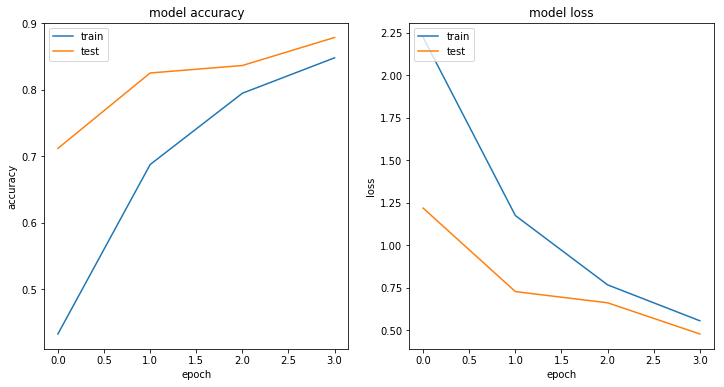

8000/8000 [==============================] - 70s 9ms/step
Final log_loss: 0.4767516372647409, epochs: 4


In [29]:
if 1:
    MODEL = vgg16_model
    model_str = 'vgg16'
    img_rows, img_cols = 224, 224
    #optimizer = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-06)
    optimizer = optimizers.SGD(lr=0.0005, momentum=0.9)
    batch_size = 32
    epochs = 4
    freeze_num = 19
    
    fine_tune_model(MODEL, img_rows, img_cols, optimizer, batch_size, epochs, freeze_num)